# 7 - Análise Exploratória de Séries Temporais - Faturamento do produto `bonificacao`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `bonificacao`.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats as spst

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'bonificacao'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].dropna().index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

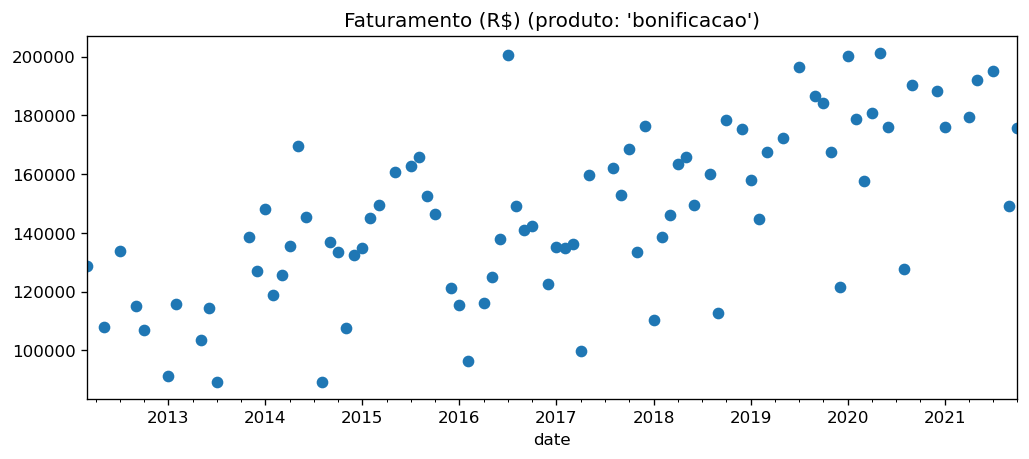

In [3]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [4]:
fat.describe()

count        86.000000
mean     146876.014620
std       28749.544736
min       89211.183185
25%      126109.507134
50%      145913.341145
75%      168398.936689
max      201331.273286
Name: bonificacao, dtype: float64

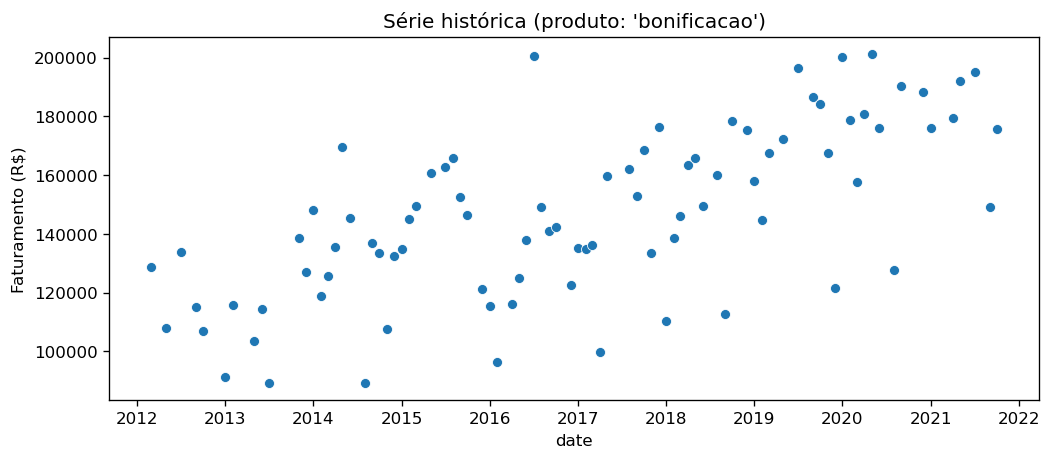

In [5]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

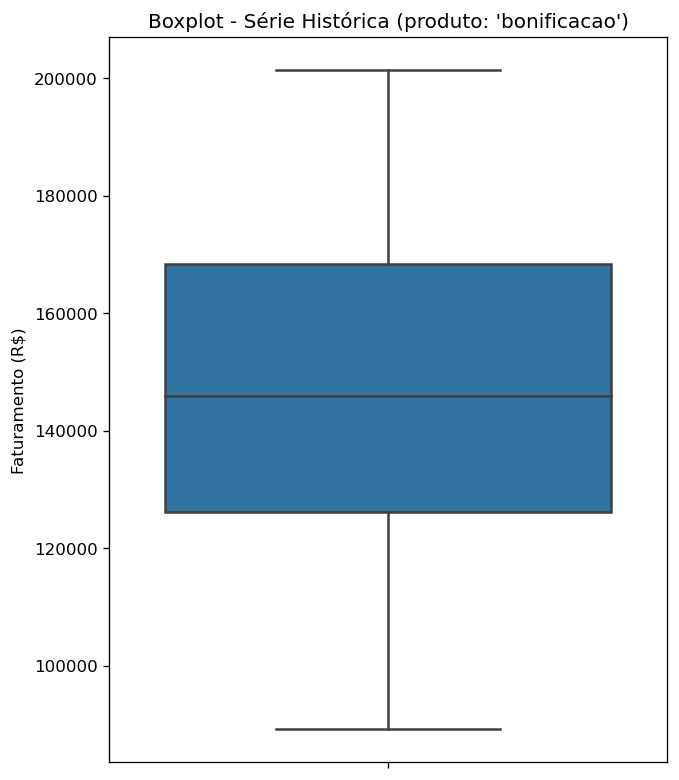

In [6]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

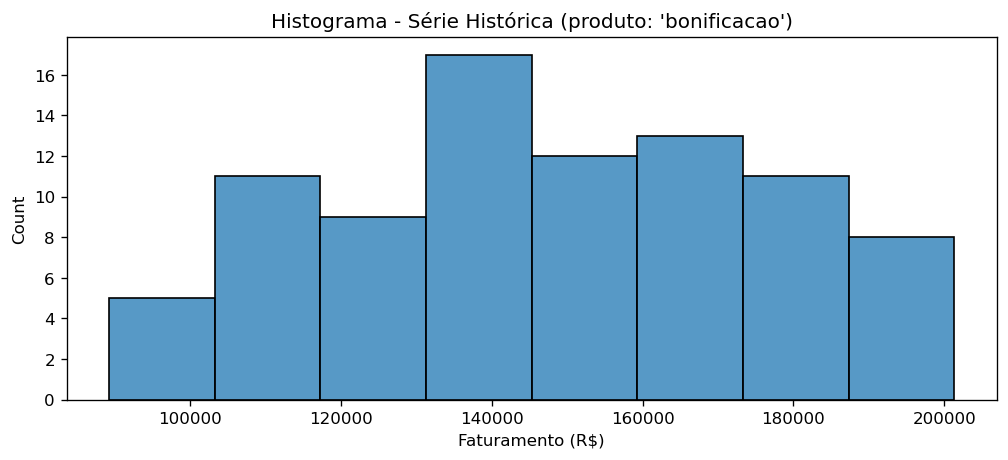

In [7]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [8]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count        33.000000
mean     168434.648490
std       22530.819106
min      112903.036433
25%      157559.908526
50%      175503.635972
75%      184069.308917
max      201331.273286
Name: bonificacao, dtype: float64

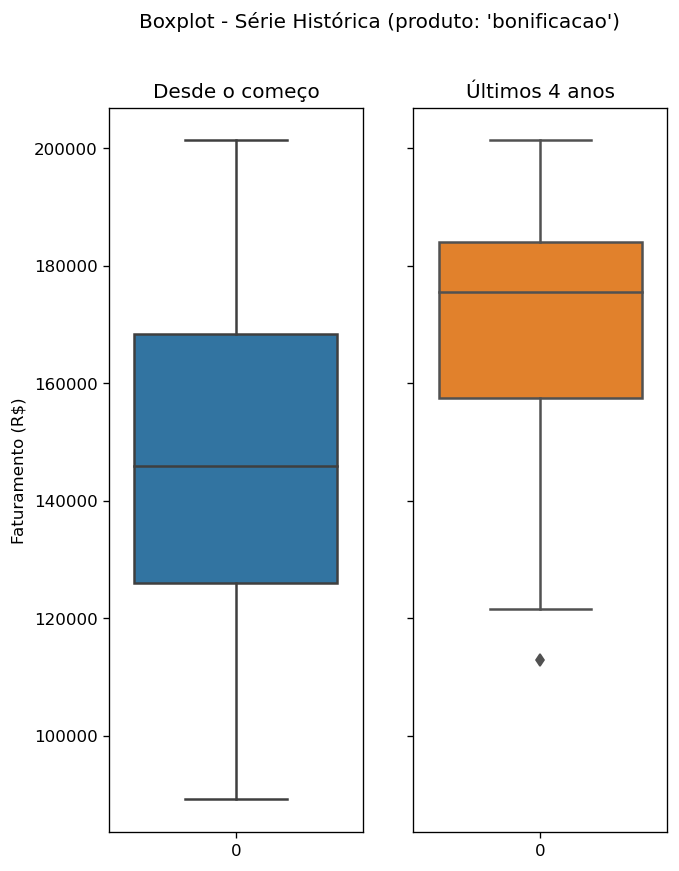

In [9]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

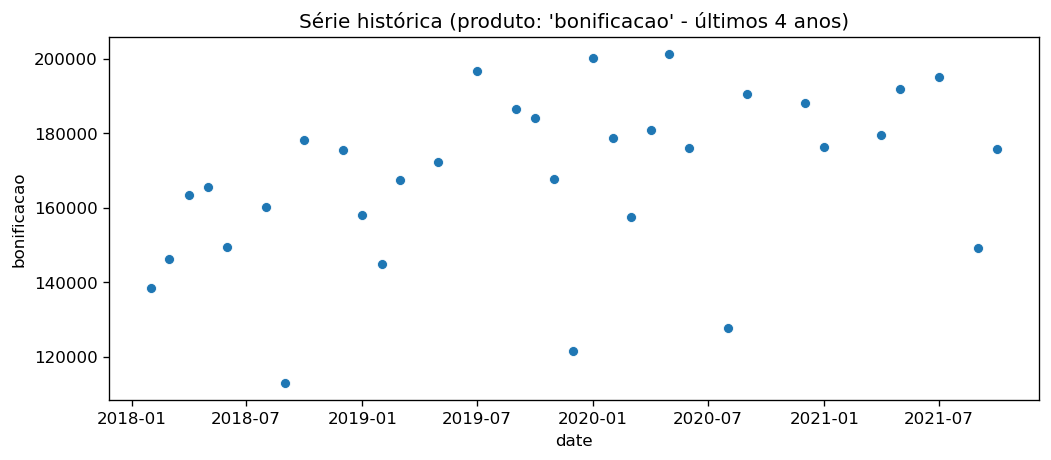

In [10]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

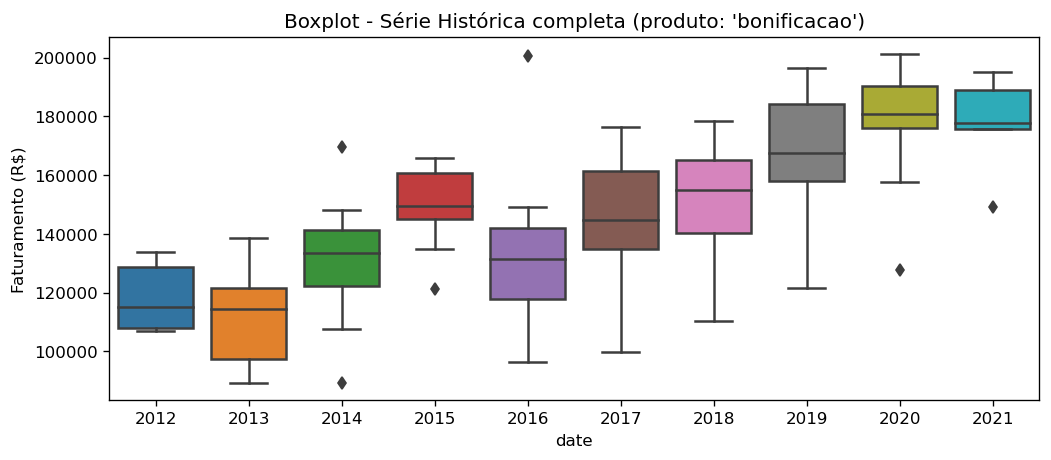

In [11]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

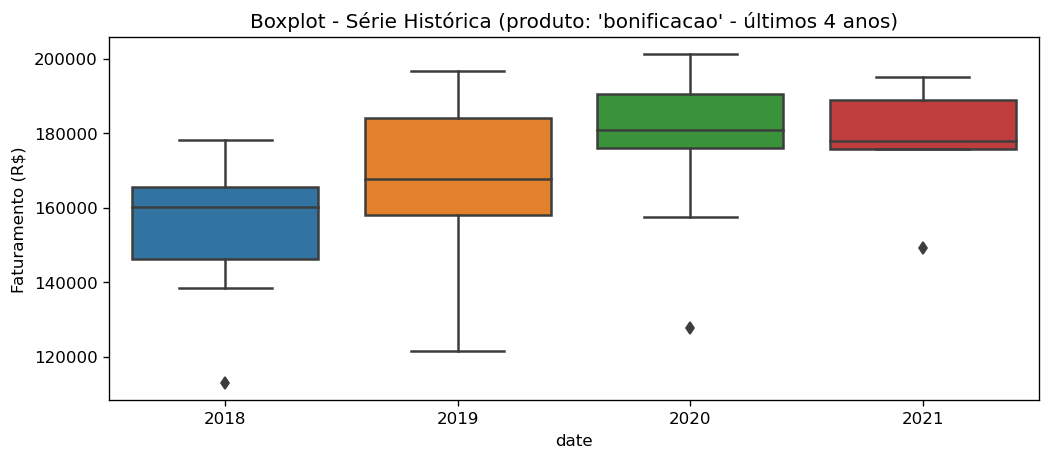

In [14]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [12]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [13]:
testedf = adfuller(fat.dropna())
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 72.132% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

In [14]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

#decomp = py_scripts.plots.decomp_fourier(serie_fat = fat, produto = analise_produto, c = c)

# ERRO. Série não pode conter valores faltando.

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos claramente seguem um padrão oscilatório.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

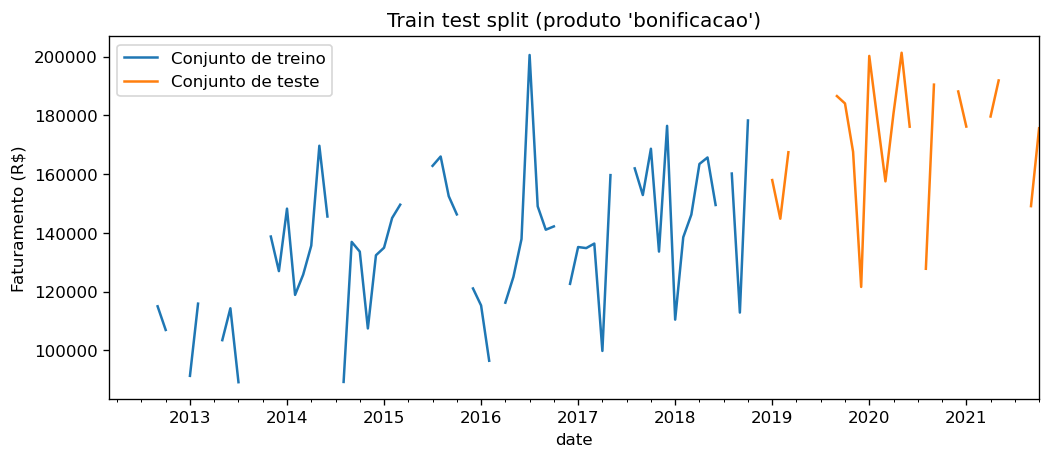

In [15]:
fat_modelo = fat

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

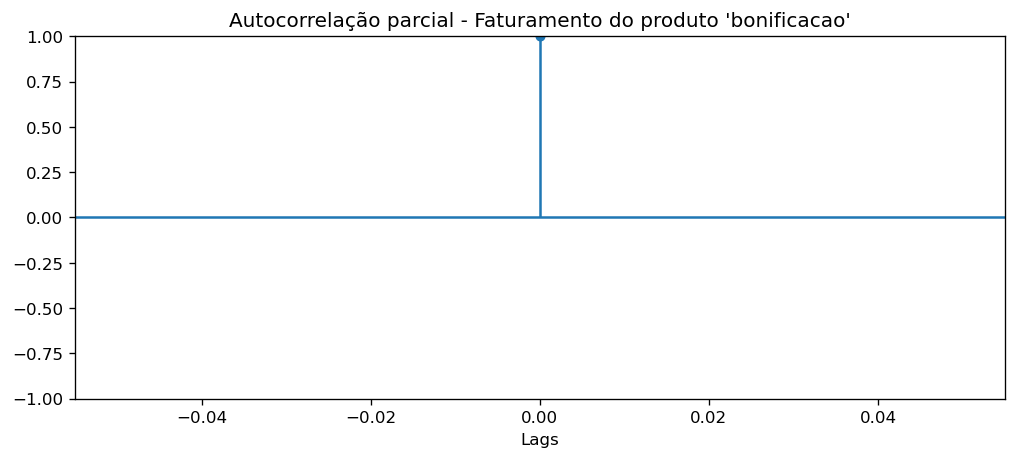

In [16]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

A função de autocorrelação não se comporta bem quando há muitos falorae faltantes na série.

Como não há nenhuma indicação acerca da ordem do modelo autorregressivo, não resta opção a não ser testar todas as combinações razoáveis:

In [20]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )
#
# ERRO: auto_arima não aceita valores faltantes. Temos que fazer manualmente


In [17]:
# total de combinações: 2048
# tempo aproximado de término da simulação: ~ 9 minutos em computador com processador Intel i7-4910MQ 2,9 GHz, 32 GB de memória RAM, rodando Windows 10

ip = pd.Series(range(0, 4), name = 'p')
id = pd.Series(range(0, 2), name = 'd')
iq = pd.Series(range(0, 4), name = 'q')

iP = pd.Series(range(0, 4), name = 'P')
iD = pd.Series(range(0, 2), name = 'D')
iQ = pd.Series(range(0, 4), name = 'Q')
iS = pd.Series([12], name = 'S')

iIntercept = pd.Series([True, False], name = 'Intercept')

aic_idx = pd.MultiIndex.from_product([ip, id, iq, iP, iD, iQ, iS, iIntercept])

aicdf = pd.DataFrame(
    [], 
    columns = ['aic', 'bic'],
    index = aic_idx
)

aic_min = np.inf

for (p, d, q, P, D, Q, S, intercept) in tqdm(aic_idx, desc = '# de combinações de ordens testadas'):

    if p + q > 3 or P + Q > 3:
        continue
    
    try:
        m = ARIMA(order = (p, d, q), seasonal_order = (P, D, Q, S), with_intercept = intercept, suppress_warnings=True).fit(y = fat_train)
    except:
        continue

    aic = m.aic()
    bic = m.bic()

    if aic < aic_min:
        aic_min = aic
        modelo = m

    aicdf.loc[(p, d, q, P, D, Q, S, intercept)] = (aic, bic)

aicdf.sort_values(by = 'aic', inplace = True)


# de combinações de ordens testadas: 100%|██████████| 2048/2048 [08:37<00:00,  3.96it/s]


In [18]:
aicdf.head(10)

aic          bic
p d q P D Q S  Intercept                          
1 0 2 0 1 1 12 False      1287.946027  1299.188503
    1 0 1 1 12 False      1288.419037  1297.413018
2 0 1 0 1 1 12 False      1288.843956  1300.086432
1 0 2 1 1 1 12 False      1289.807691  1303.298662
      0 1 2 12 False      1289.837533  1303.328505
    1 1 1 1 12 False      1290.166642  1301.409119
      0 1 2 12 False      1290.206356  1301.448832
2 0 1 1 1 1 12 False      1290.723191  1304.214163
      0 1 2 12 False      1290.749987  1304.240959
1 0 2 2 1 1 12 False      1291.613978  1307.353445

In [19]:
modelo = ARIMA(
    order = (1, 0, 2), 
    seasonal_order = (0, 1, 1, 12), 
    with_intercept = False
).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [20]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -638.973
Date:                              Mon, 22 Nov 2021   AIC                           1287.946
Time:                                      17:14:49   BIC                           1299.189
Sample:                                           0   HQIC                          1292.412
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9847      0.020     49.177      0.000       0.945       1.024
ma.L1         -0.7132      0.250     -2.851      0.004      -1.203      -0.223
ma.L2         -0.1321      0.279     -0.474      0.635      -0.678       0.414
ma.S.L12      -0.6815      0.300     -2.268      0.023      -1.270      -0.092
sigma2      8.117e+08   8.28e-11    9.8e+18      0.000    8.12e+08    8.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.95   Prob(JB):                         0.76
Heteroskedasticity (H):               0.97   Skew:                             0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+36. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

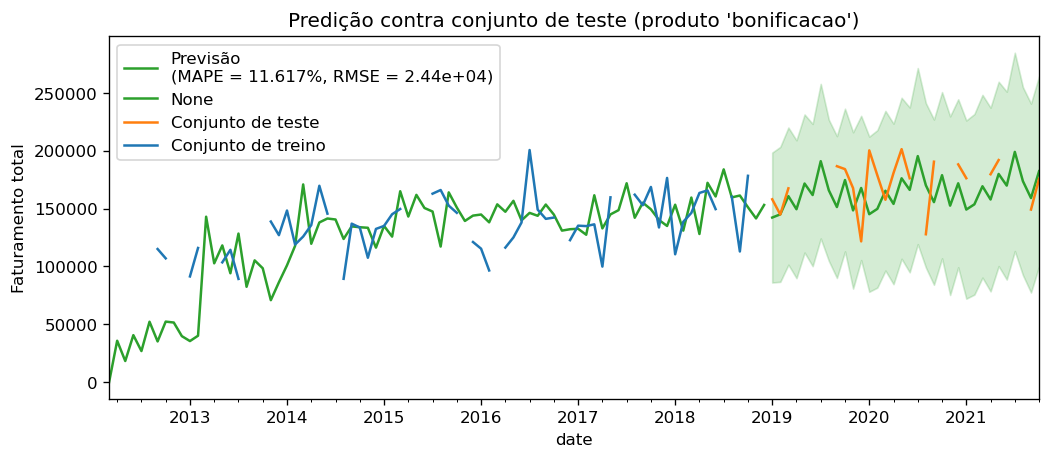

In [21]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

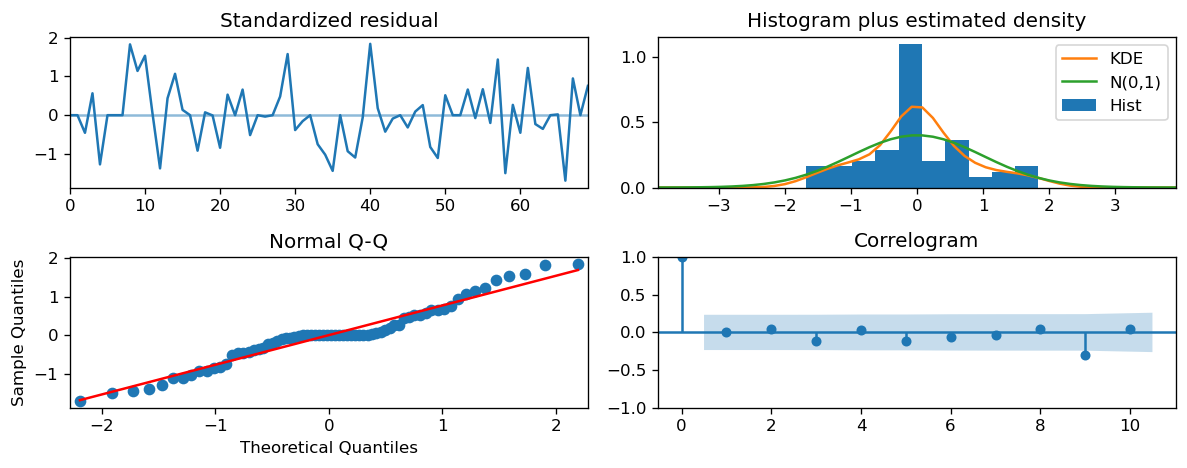

In [22]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [23]:
kwargs_total = dict(
    y_true = fat_test.dropna(),
    y_pred = preds.loc[fat_test.dropna().index],
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 11.617%
       RMSE: 2.444e+04
        MAE: 1.949e+04


## Modelo autorregressivo com probabilidade de zero

Até o momento, desenvolvemos o raciocínio assumindo que os dados faltantes (os meses em que o faturamento do produto `bonificacao` não está disponível) eram simples erros de registro.

Um outra interpretação é possível: os valores faltantes representam meses em que não houve faturamento para esse produto. Neste caso, os valores faltantes devem ser equivalentes a zero.

Vejamos como isso muda nossa modelagem.

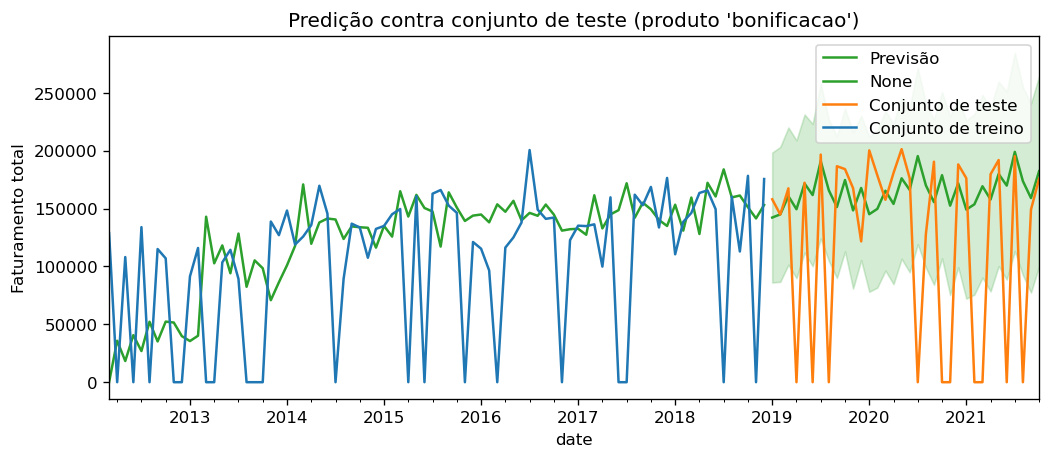

In [24]:
fat0 = fat.fillna(0)
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train.fillna(0),
    serie_teste = fat_test.fillna(0),
    ci = True,
    in_sample = True,
    preds_metrics = False
)

### EDA

Vamos investigar se há algum padrão segundo o qual os zeros estão distribuídos.

#### Por ano

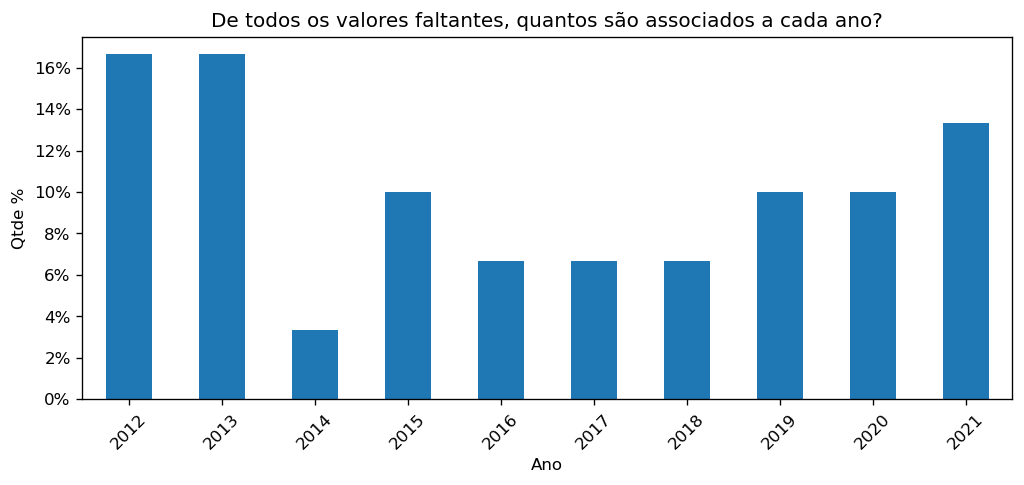

In [25]:
fat0_ano = fat0[fat0 == 0].index.year.value_counts(normalize = True).sort_index()

fig = plt.figure()
ax = fig.gca()

fat0_ano.plot(kind = 'bar', ax = ax)

ax.set_title('De todos os valores faltantes, quantos são associados a cada ano?')

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('Qtde %')

ax.set_xlabel('Ano')
ax.xaxis.set_tick_params(rotation=45)

plt.show()

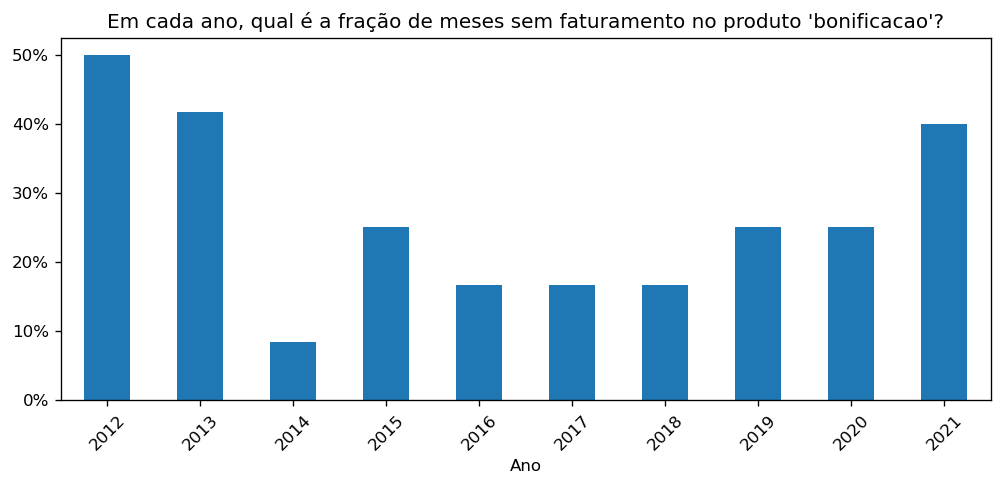

In [26]:
fat0_pctano = fat0[fat0 == 0].index.year.value_counts() / fat0.index.year.value_counts()

fig = plt.figure()
ax = fig.gca()

fat0_pctano.plot(kind = 'bar', ax = ax)

ax.set_title("Em cada ano, qual é a fração de meses sem faturamento no produto 'bonificacao'?")

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')

ax.set_xlabel('Ano')
ax.xaxis.set_tick_params(rotation = 45)

plt.show()

#### Por mês do ano

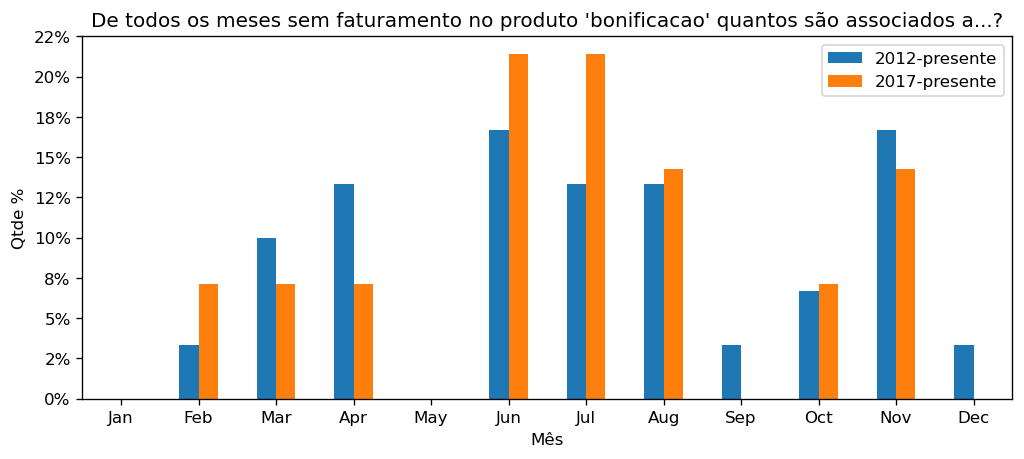

In [27]:
fig = plt.figure()
ax = fig.gca()

fat_mes = fat0[fat0 == 0].index.month.value_counts(normalize = True).sort_index()
fat_mes_recente = fat0[(fat0 == 0) & (fat0.index >= '2017')].index.month.value_counts(normalize = True).sort_index()

fat_mes = fat_mes.reindex(range(1, 13))
fat_mes.index = np.vectorize(lambda m: dt.date.strftime(dt.date(year = 1970, month = m, day = 1), format = '%b'))(fat_mes.index)

fat_mes_recente = fat_mes_recente.reindex(range(1, 13))
fat_mes_recente.index = fat_mes.index

df_fat_mes = pd.DataFrame({
    '2012-presente': fat_mes,
    '2017-presente': fat_mes_recente
})

palette = sns.color_palette(None, 2)
df_fat_mes.plot(label = '2012-presente', kind = 'bar', ax = ax)

ax.set_title("De todos os meses sem faturamento no produto 'bonificacao' quantos são associados a...?")

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('Qtde %')

ax.set_xlabel('Mês')
ax.xaxis.set_tick_params(rotation=0)
plt.legend()
plt.show()

Destes gráficos, concluímos que há a possibilidade de construirmos um modelo do tipo Bernoulli, com uma probabilidade `p` a ser determinada, para predizermos se em determinado mês o faturamento do produto `bonificacao` será zero ou não. Caso não seja, então aplicamos o modelo `SARIMA` que desenvolvemos na seção anterior.

### Análise de série temporal com modelo logístico

No entanto, o problema com análise de séries temporais é que os valores frequentemente são autocorrelacionados, *i.e.* o valor do faturamento em um mês tem correlação com os meses anteriores.

No caso em tela, precisamos prever se o faturamento em um mês $t$ será 0 ou não. Podemos usar um modelo de regressão logística caso a série binária (em cada mês, True se o faturamento for zero, e False caso contrário) não for autocorrelacionada:

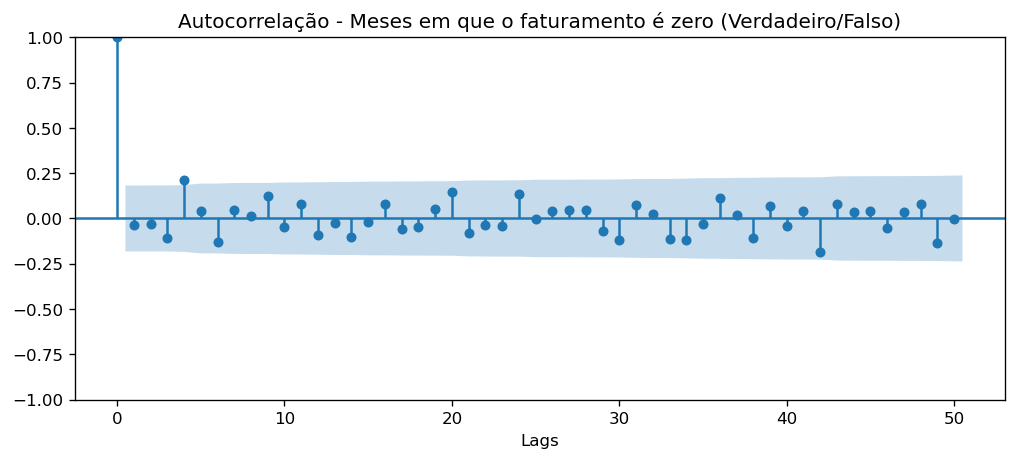

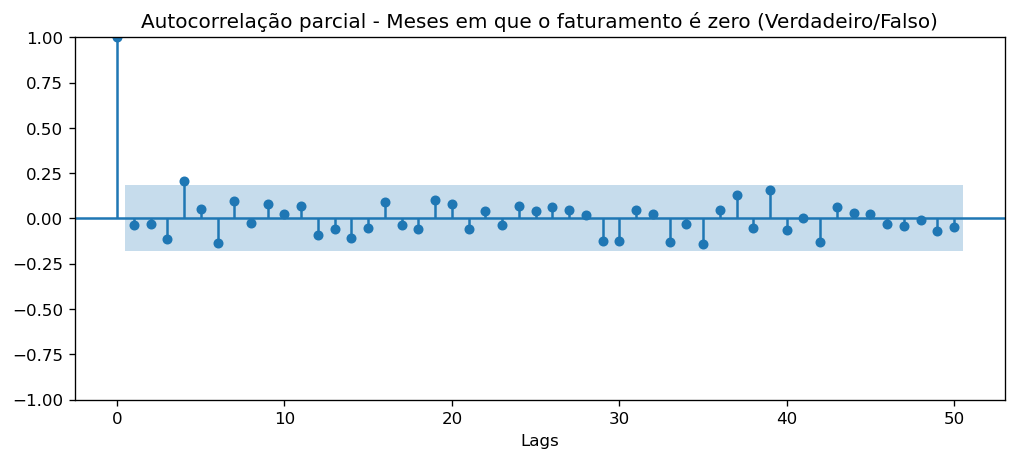

In [28]:
fat_is0 = fat0 == 0

fig = plt.figure()
ax = fig.gca()
plot_acf(fat_is0, lags = 50, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação - Meses em que o faturamento é zero (Verdadeiro/Falso)")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_is0, lags = 50, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Meses em que o faturamento é zero (Verdadeiro/Falso)")
plt.show()

De fato, a série binária que descrevemos não é autocorrelacionada, o que facilita sobremaneira a análise.

### Regressão logística

Vamos aplicar uma simples regressão logística, onde a variável independente é o número de meses desde janeiro de 2017, e a variável dependente é se o faturamento é zero ou não.

In [29]:
series_begin = '2017'

fat0_logreg = fat0[series_begin:]

X = fat0_logreg.reset_index().index.values.reshape(-1, 1)
y = (fat0_logreg == 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# sc = StandardScaler()

# X_train = sc.fit_transform(X_train_unscaled)
# X_test = sc.transform(X_test_unscaled)
# X_train = X_train_unscaled
# X_test = X_test_unscaled

bonusreg = LogisticRegression()
bonusreg.fit(X_train, y_train)

LogisticRegression()

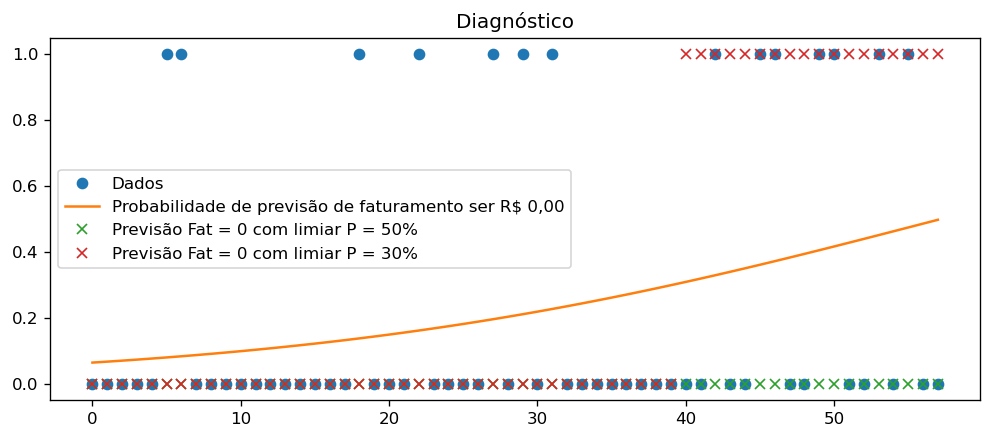

In [31]:
classification_threshold = 0.3

y_probs_full = bonusreg.predict_proba(X)
y_probs = y_probs_full[:, 1]

y_pred_all = bonusreg.predict(X)

plt.plot(X, y, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(X, y_probs, label = 'Probabilidade de previsão de faturamento ser R$ 0,00')
plt.plot(X, y_pred_all, marker = 'x', linestyle = '', label = 'Previsão Fat = 0 com limiar P = 50%')
plt.plot(X, y_probs > 0.30, marker = 'x', linestyle = '', label = f'Previsão Fat = 0 com limiar P = {classification_threshold:.0%}')

plt.legend()
plt.title('Diagnóstico')
plt.show()

Estamos interessados no valor da probabilidade de o modelo prever que o faturamento será de R$ 0,00 no mês em questão.

In [33]:
p_fat0 = spst.bernoulli(p = y_probs)

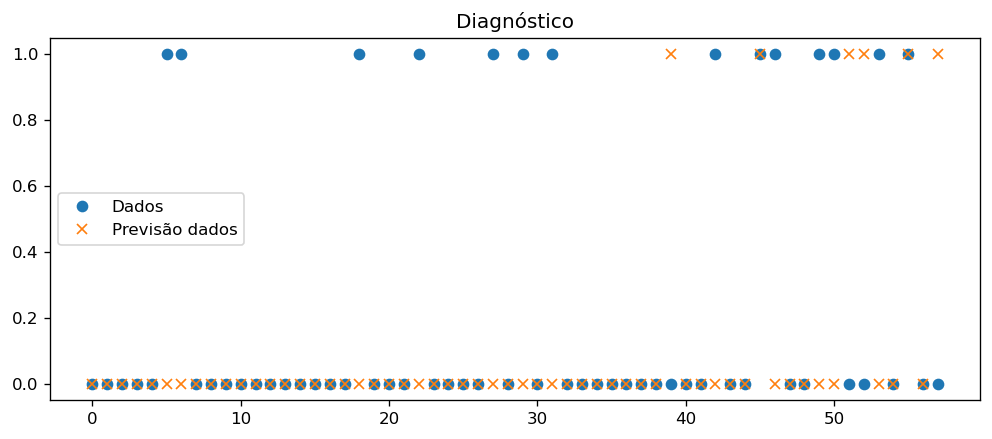

In [34]:
y_preds_pred = p_fat0.rvs(size = y_probs.shape)

fig = plt.figure()
ax = fig.gca()

plt.plot(X, y, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(X, y_preds_pred, marker = 'x', linestyle = '', label = 'Previsão dados')

plt.legend()
plt.title('Diagnóstico')
plt.show()

Visualmente, parece que o modelo preve razoavelmente a quantidade de meses em que o faturamento é zero.

### Modelo

Vamos construir uma classe cuja API é igual ao da classe `ARIMA` (que usamos até o momento para construir os outros modelos).

In [35]:
## W.I.P.

class ARIMA_zeros(ARIMA):

    def __init__(self, series_begin = '2017', *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.fat0_model_series_begin = series_begin
    
    def fit(self, *args, **kwargs):
        super().fit(*args, **kwargs)

        try:
            fat0 = args[0]
        except IndexError:
            fat0 = kwargs['y']

        fat0 = fat0.fillna(0)[self.fat0_model_series_begin:]
        
        # lembrando que o fit já é no conjunto de treino. Não é necessário fazer o train-test-split novamente
        X_train = fat0.reset_index().index.values.reshape(-1, 1)
        y_train = (fat0 == 0).values

        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

        # sc = StandardScaler()

        # X_train = sc.fit_transform(X_train_unscaled)
        # X_test = sc.transform(X_test_unscaled)
        # X_train = X_train_unscaled
        # X_test = X_test_unscaled

        bonusreg = LogisticRegression()
        bonusreg.fit(X_train, y_train)

        self.fat0_model = bonusreg
        self.fat0_model_endog = fat0
        self.fat0_model_series_begin_idx = self.arima_res_.data.endog.shape[0] - fat0.shape[0]

        return self
    
    def predict(self, *args, **kwargs):
        y = super().predict(*args, **kwargs)

        try:
            n_periods = args[0]
        except IndexError:
            n_periods = kwargs['n_periods']
    
        endog = self.fat0_model_endog
        predict_first = len(endog) + 1
        predict_last = predict_first + n_periods
        X = np.arange(predict_first, predict_last).reshape(-1, 1)
        y_probs_full = self.fat0_model.predict_proba(X)
        y_probs = y_probs_full[:, 0]

        p_fat0 = spst.bernoulli(p = y_probs)
        y_preds_pred = p_fat0.rvs(size = y_probs.shape)

        y0 = y * y_preds_pred

        return y0
    
    def predict_proba(self, *args, **kwargs):
        return self.fat0_model.predict_proba(*args, **kwargs)
    
    def predict_in_sample(self, *args, **kwargs):
        y = super().predict_in_sample(*args, **kwargs)
        fat0_endog = self.fat0_model_endog

        X = np.arange(-self.fat0_model_series_begin_idx, fat0_endog.shape[0]).reshape(-1, 1)
        
        y_probs_full = self.fat0_model.predict_proba(X)
        y_probs = y_probs_full[:, 0]

        p_fat0 = spst.bernoulli(p = y_probs)
        y_preds_pred = p_fat0.rvs(size = y_probs.shape)

        y0 = y * y_preds_pred

        return y0


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


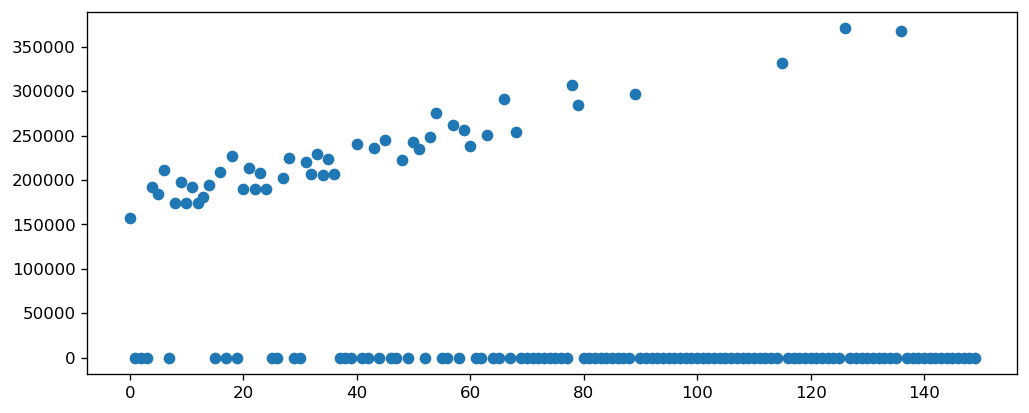

In [36]:
modelo0 = ARIMA_zeros(
    order = (1, 0, 2), 
    seasonal_order = (0, 1, 1, 12), 
    with_intercept = True,
    series_begin = '2017'
).fit(y = fat_train)

n_periods = 150
x = np.arange(0, n_periods)
y = modelo0.predict(n_periods)
plt.plot(x, y, marker = 'o', linestyle = '')
plt.show()

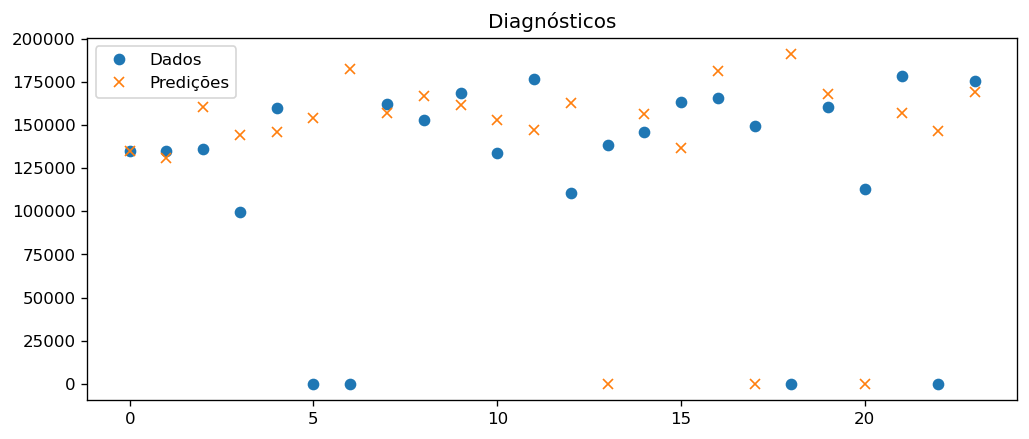

In [37]:
n_periods = modelo0.fat0_model_endog.shape[0]

fat0_series_begin_idx = modelo0.fat0_model_series_begin_idx

x = np.arange(0, n_periods)
y0 = modelo0.predict_in_sample(n_periods)[fat0_series_begin_idx:]
y1 = fat_train.fillna(0).iloc[fat0_series_begin_idx:].values

plt.plot(x, y1, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(x, y0, marker = 'x', linestyle = '', label = 'Predições')

plt.legend()
plt.title('Diagnósticos')
plt.show()

Novamente, parece que o modelo prevÊ adequadamente o faturamento e a frequência de meses em que o faturamento é 0.

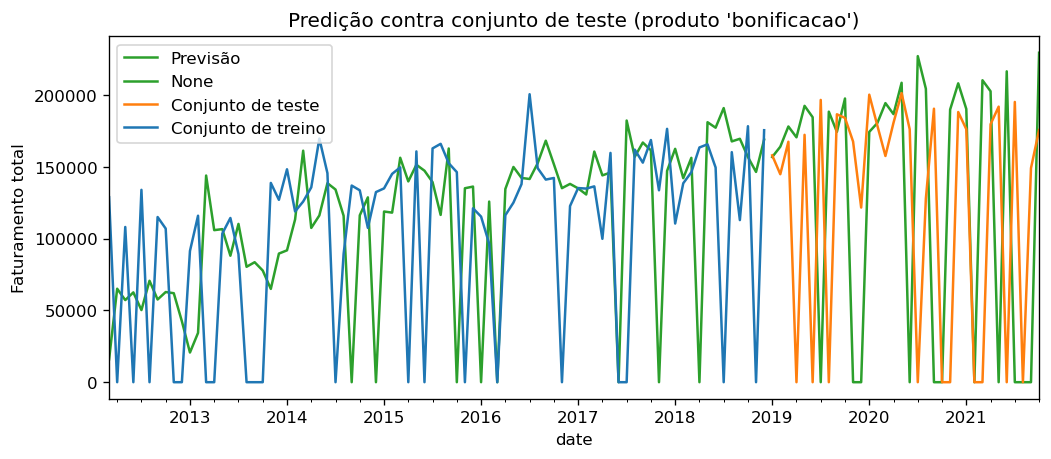

In [38]:
fat0 = fat.fillna(0)
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo0, 
    produto = analise_produto,
    serie_treino = fat_train.fillna(0),
    serie_teste = fat_test.fillna(0),
    in_sample = True,
    preds_metrics = False
)

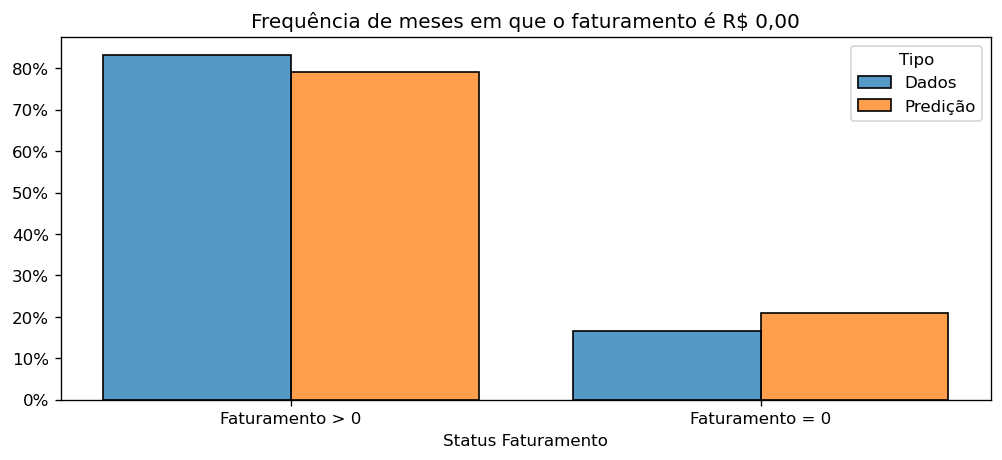

In [39]:
n_periods = modelo0.fat0_model_endog.shape[0]

fat0_series_begin_idx = modelo0.fat0_model_series_begin_idx

x = np.arange(0, n_periods)
y0 = modelo0.predict_in_sample(n_periods)[fat0_series_begin_idx:] == 0
y1 = fat_train.fillna(0).iloc[fat0_series_begin_idx:].values == 0

dfcount_wide = pd.DataFrame(
    {'Dados': y1,
    'Predição': y0},
    index = x
).reset_index()

dfcount = pd.melt(dfcount_wide, id_vars = 'index', var_name = 'Tipo', value_name = 'fat0')
dfcount['Status Faturamento'] = dfcount['fat0'].map({True: 'Faturamento = 0', False: 'Faturamento > 0'})
dfcount.rename(columns = {'index': 'meses_apos'}, inplace=True)

ax = sns.histplot(data = dfcount, x = 'Status Faturamento', hue = 'Tipo', multiple = 'dodge', shrink = 0.8, stat = 'density', common_norm = False)
ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('')

plt.title('Frequência de meses em que o faturamento é R$ 0,00')
plt.show()

Parece que o modelo da frequência de meses em que o faturamento é zero se ajusta bem aos dados.